In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import sparse
from scipy.sparse.linalg import svds
from scipy import linalg

import pyemb as eb

In [2]:
np.random.seed(42)

### Load dataset

In [3]:
window = 15*60

day_1_start = (8*60+30)*60
day_1_end = (17*60+30)*60
day_2_start = ((24+8)*60+30)*60
day_2_end = ((24+17)*60+30)*60

T1 = int((day_1_end - day_1_start) // window)
T2 = int((day_2_end - day_2_start) // window)
T = T1 + T2

print(f'Number of time windows: {T}')

fname = 'data/ia-primary-school-proximity-attr.edges'
file = open(fname)

nodes = []
node_labels = []
edge_tuples = []

for line in file:
    node_i, node_j, time, id_i, id_j = line.strip('\n').split(',')
    
    if day_1_start <= int(time) < day_1_end:
        t = (int(time) - day_1_start) // window
    elif day_2_start <= int(time) < day_2_end:
        t = T1 + (int(time) - day_2_start) // window
    else:
        continue
    
    if node_i not in nodes:
        nodes.append(node_i)
        if id_i != "Teachers":
            id_i = "Class " + id_i
        node_labels.append(id_i)
    
    if node_j not in nodes:
        nodes.append(node_j)
        if id_j != "Teachers":
            id_j = "Class " + id_j
        node_labels.append(id_j)
    
    edge_tuples.append([t, node_i, node_j])
    
edge_tuples = np.unique(edge_tuples, axis=0)
nodes = np.array(nodes)

n = len(nodes)
print(f'Number of nodes: {n}')

node_dict = dict(zip(nodes[np.argsort(node_labels)], range(n)))
node_labels = np.sort(node_labels)

As = []
for t in range(T):
    idx = np.where(edge_tuples[:, 0] == str(t))[0]
    A = sparse.coo_matrix((np.ones(len(idx)), ([node_dict[edge_tuples[i, 1]] for i in idx], [node_dict[edge_tuples[i, 2]] for i in idx])), shape=(n,n))
    As.append((A + A.T).sign())

Number of time windows: 72
Number of nodes: 242


### Embed the dynamic network

In [4]:

# Embed the graph using unfolded regularised Laplacian spectral embedding
d = 10
URLSE_emb = eb.dyn_embed(As, d=d, method="URLSE")

### Quick visualisations

In [5]:
# Quick animation of the embedding
eb.quick_plot(URLSE_emb, n, T, node_labels)

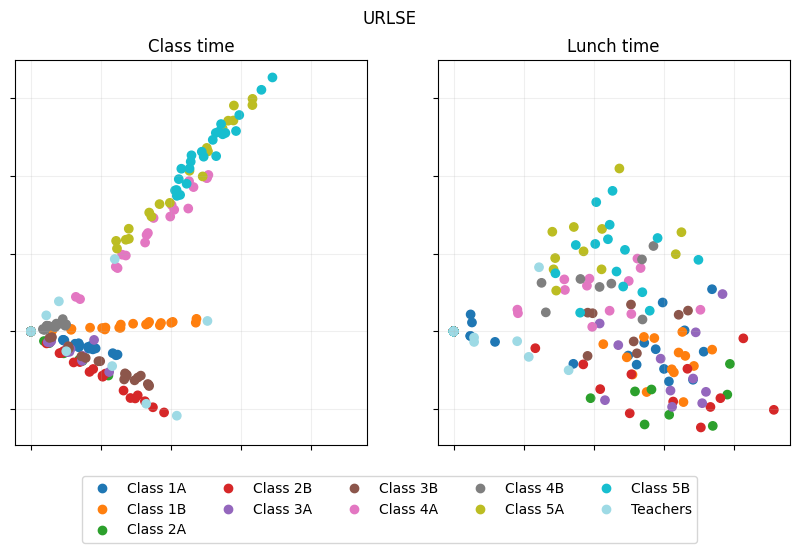

In [6]:
URLSE_emb = eb.dyn_embed(As, d=d, method="URLSE", flat=False)

# Select snapshots to be shown
points_of_interest = [5, 14]
point_labels = ["Class time", "Lunch time"]

# Plot the snapshots
fig = eb.snapshot_plot(
    URLSE_emb, 
    n, 
    node_labels, 
    points_of_interest, 
    point_labels, 
    add_legend=True, 
    legend_adjust=-0.1, # adjust the vertical height of the legend
    cmap="tab20"
)

# Apply any further adjustments to the plot
_ = fig.suptitle("URLSE")

### Degree-correct the embedding

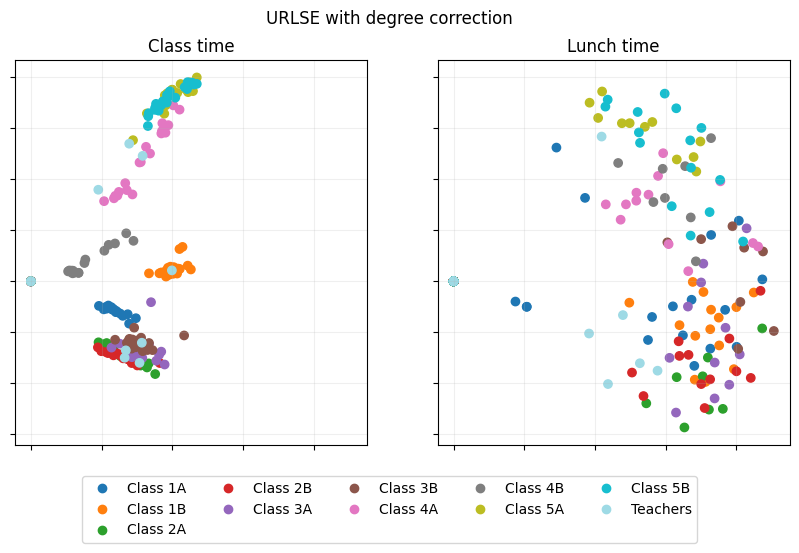

In [7]:
URLSE_emb_dc = eb.degree_correction(URLSE_emb)
URLSE_fig = eb.snapshot_plot(
    URLSE_emb_dc, 
    n, 
    node_labels, 
    points_of_interest, 
    point_labels, 
    add_legend=True, 
    legend_adjust=-0.1,
    cmap="tab20"
)
_ = URLSE_fig.suptitle("URLSE with degree correction")

## Compare embedding methods

#### Independent spectral embedding

A naive dynamic embedding method where each adjacency matrix is embedded independently using spectral embedding.

As each time point is entirely independent temporal structure is lost, which is illustrated by no two time points looking at all alike.  

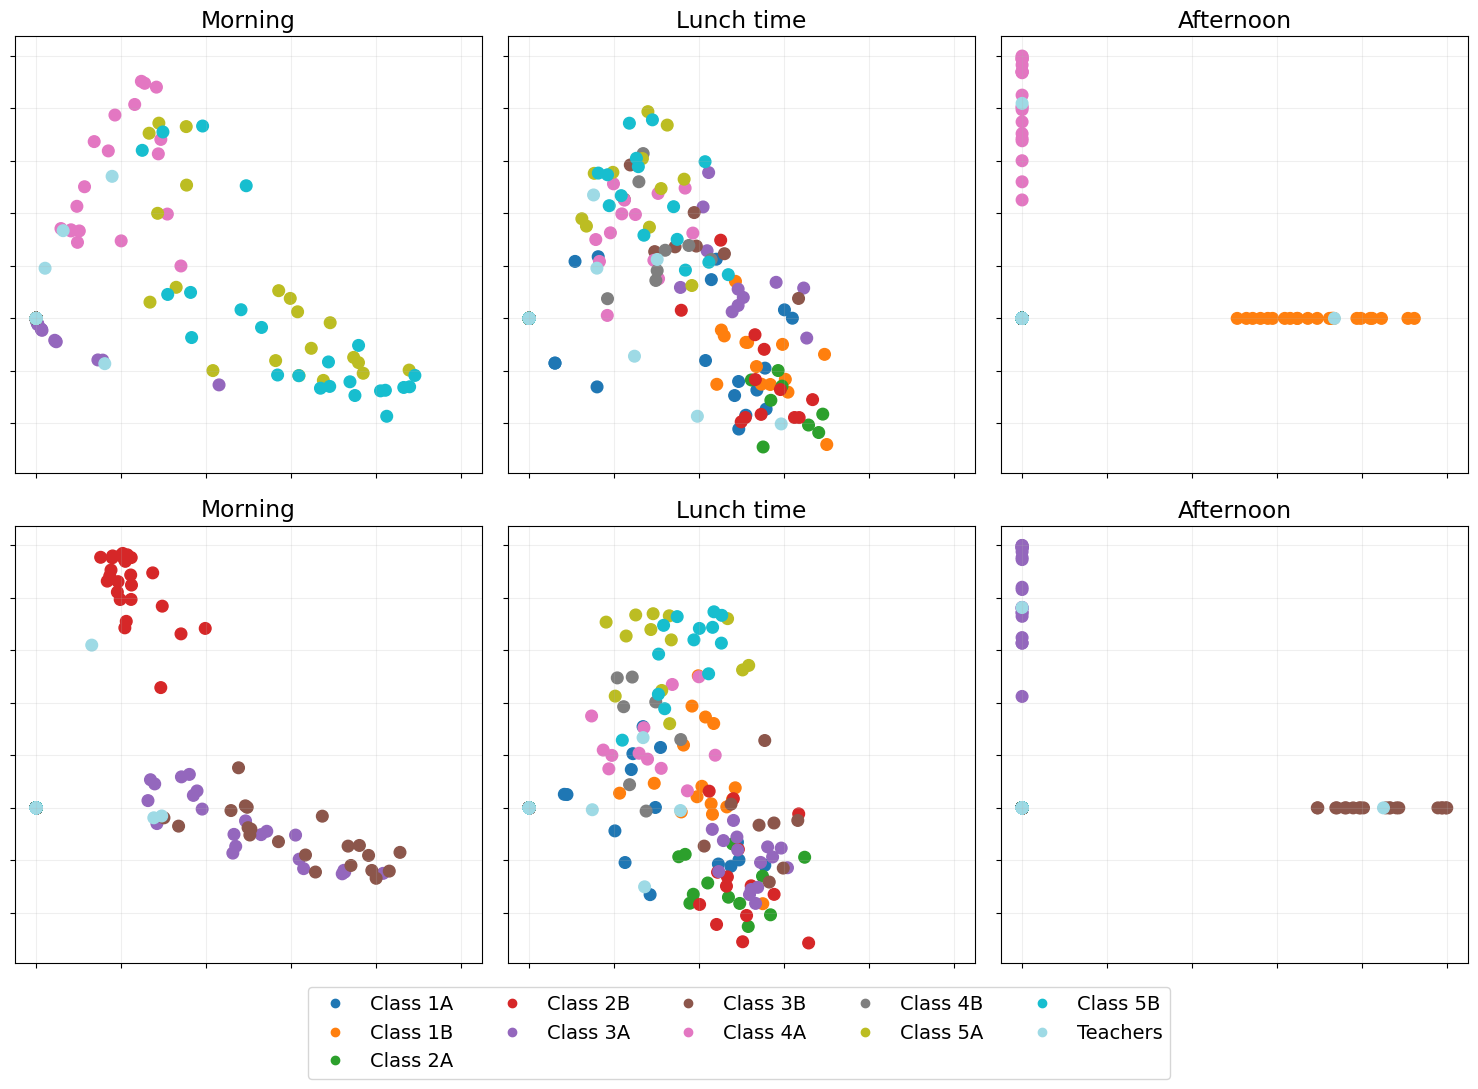

In [16]:
ISE_emb = eb.dyn_embed(As, d, method="ISE")
ISE_emb = eb.degree_correction(ISE_emb)

points_of_interest = [5, 14, 27, 41, 50, 63]
point_labels = ["Morning", "Lunch time", "Afternoon"] * 2

# Adjust the text size on the plot
plt.rcParams.update({'font.size': 14})

ISE_fig = eb.snapshot_plot(
    ISE_emb, 
    n, 
    node_labels, 
    points_of_interest, 
    point_labels, 
    max_cols=3,     # maximum number of columns in the plot
    add_legend=True, 
    legend_adjust=-0.1,
    
    # Apply other matplotlib settings
    cmap="tab20",
    s=70,
)
plt.tight_layout()

### Omnibus embedding (OMNI)

The OMNI embedding [1] manages to fix the problem of time points looking completely different, as shown by classes remaining in similar places across all time points. 

However, at lunchtime we expect classes to mix, children play with children from other classes at lunch time. OMNI fails to show this mixing as (e.g. the orange class clearly does not mix).

[1] Levin, Keith, et al. "A central limit theorem for an omnibus embedding of multiple random dot product graphs." 2017 IEEE international conference on data mining workshops (ICDMW). IEEE, 2017.

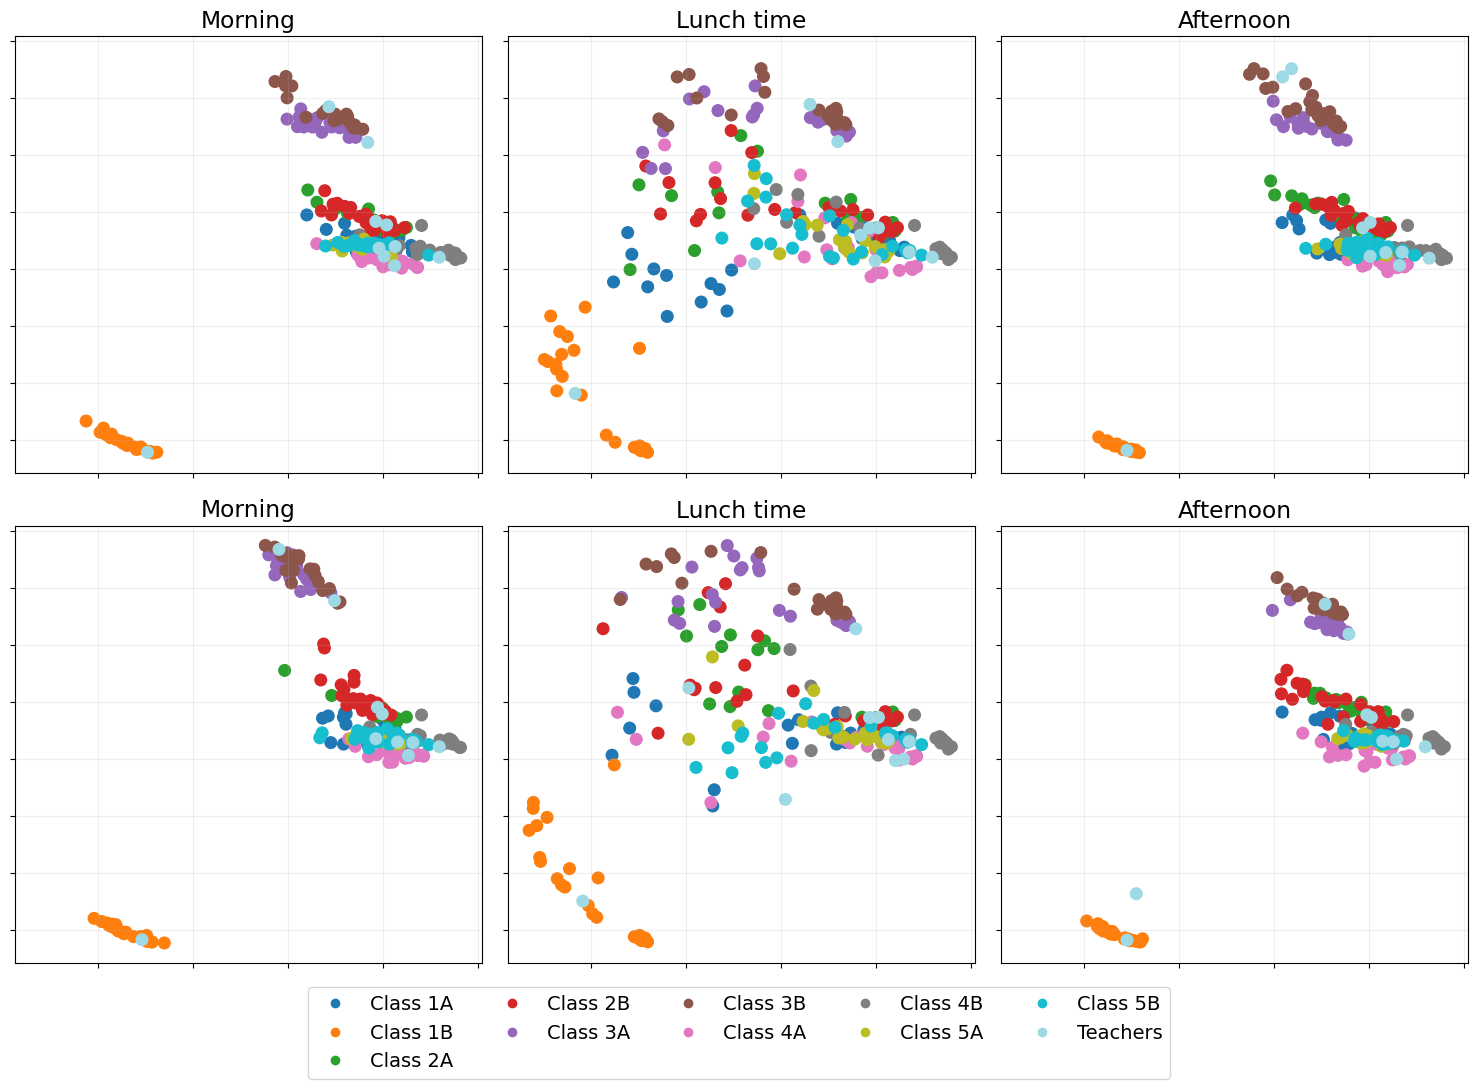

In [17]:
OMNI_emb = eb.dyn_embed(As, d, method="OMNI")
OMNI_emb = eb.degree_correction(OMNI_emb)

points_of_interest = [5, 14, 27, 41, 50, 63]
point_labels = ["Morning", "Lunch time", "Afternoon"] * 2

OMNI_fig = eb.snapshot_plot(
    OMNI_emb, 
    n, 
    node_labels, 
    points_of_interest, 
    point_labels, 
    max_cols=3,     # maximum number of columns in the plot
    add_legend=True, 
    legend_adjust=-0.1,
    
    # Apply other matplotlib settings
    cmap="tab20",
    s=70,
)
plt.tight_layout()

#### UASE

Unfoled adjacency spectral embedding (UASE) [2, 3] was the first of a suite of "unfolded" dynamic embedding methods. Owing to its property of stability [3], UASE is able to show both the clustering of classes in classtime as well as the total mixing of classes at lunchtime.

[2] Jones, Andrew, and Patrick Rubin-Delanchy. "The multilayer random dot product graph." arXiv preprint arXiv:2007.10455 (2020).

[3] Gallagher, Ian, Andrew Jones, and Patrick Rubin-Delanchy. "Spectral embedding for dynamic networks with stability guarantees." Advances in Neural Information Processing Systems 34 (2021): 10158-10170.

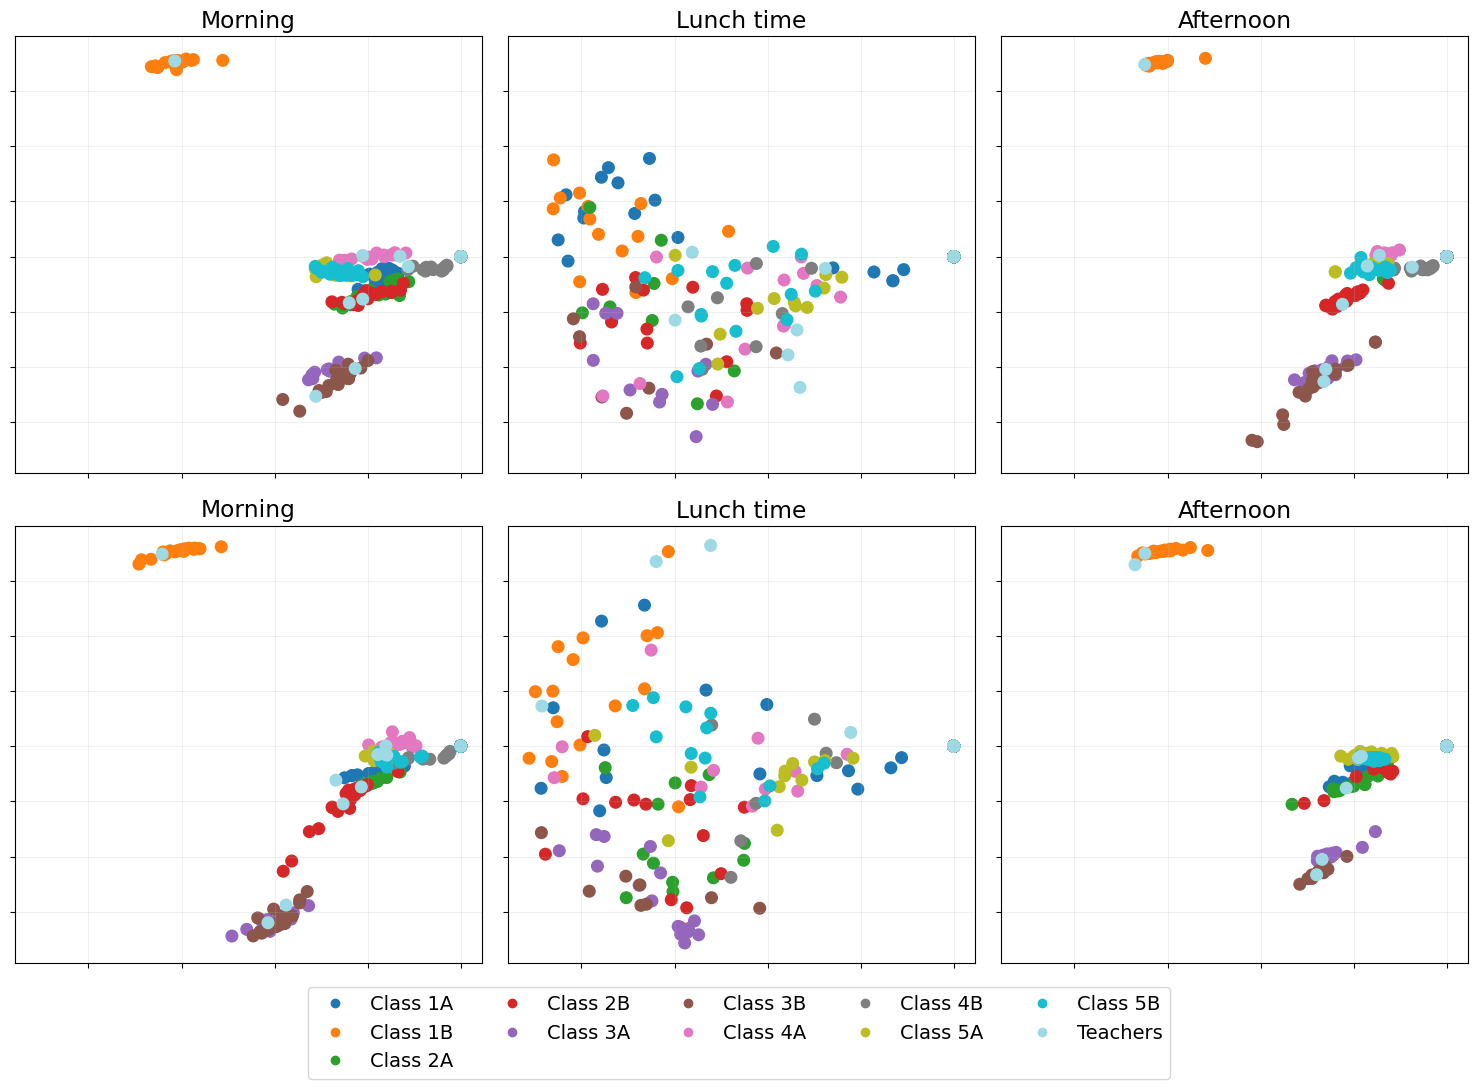

In [18]:
UASE_emb = eb.dyn_embed(As, d, method="UASE")
UASE_emb = eb.degree_correction(UASE_emb)

points_of_interest = [5, 14, 27, 41, 50, 63]
point_labels = ["Morning", "Lunch time", "Afternoon"] * 2

UASE_fig = eb.snapshot_plot(
    UASE_emb, 
    n, 
    node_labels, 
    points_of_interest, 
    point_labels, 
    max_cols=3,     # maximum number of columns in the plot
    add_legend=True, 
    legend_adjust=-0.1,
    
    # Apply other matplotlib settings
    cmap="tab20",
    s=70,
)
plt.tight_layout()

#### URLSE

Unfolded regularised Laplacian spectral embedding (URLSE) is essentially a regularised version of UASE. URLSE is one of many possible unfolded dynamic embedding, all of which feature stability properties [4]. This means that, like UASE, this method is able to display the clustering of classes in classtime and the mixing of classes at lunchtime. 

[4] Davis, Ed, et al. "A simple and powerful framework for stable dynamic network embedding." arXiv preprint arXiv:2311.09251 (2023).

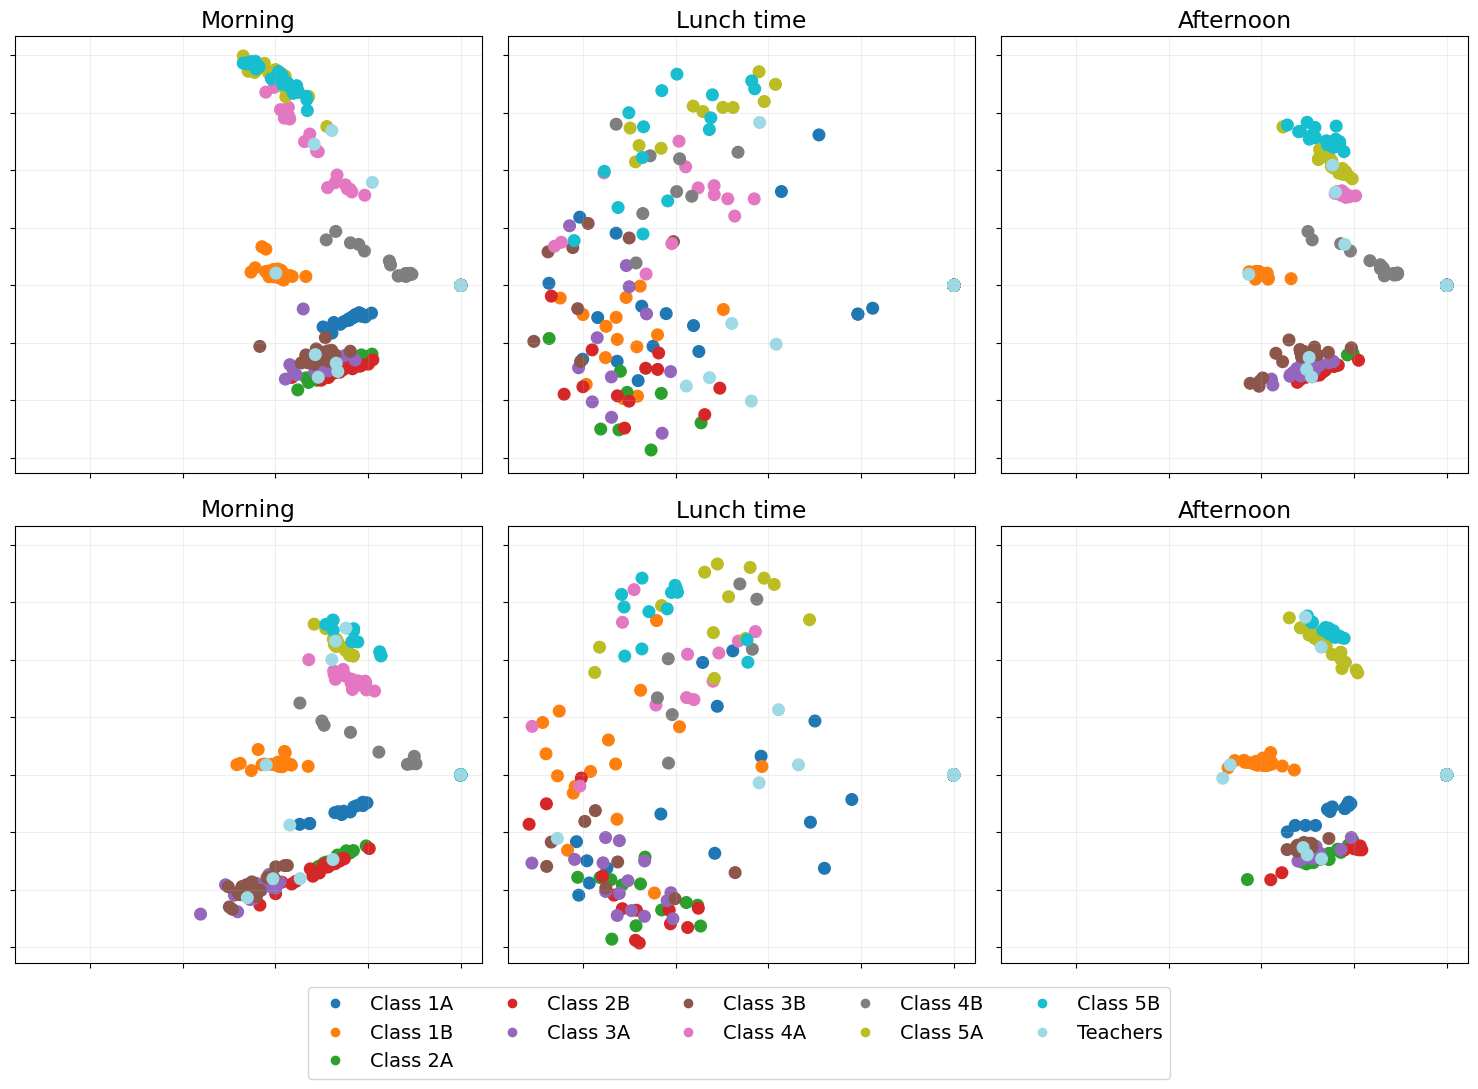

In [19]:
URLSE_emb = eb.dyn_embed(As, d, method="URLSE")
URLSE_emb = eb.degree_correction(URLSE_emb)

points_of_interest = [5, 14, 27, 41, 50, 63]
point_labels = ["Morning", "Lunch time", "Afternoon"] * 2

URLSE_fig = eb.snapshot_plot(
    URLSE_emb, 
    n, 
    node_labels, 
    points_of_interest, 
    point_labels, 
    max_cols=3,     # maximum number of columns in the plot
    add_legend=True, 
    legend_adjust=-0.1,
    
    # Apply other matplotlib settings
    cmap="tab20",
    s=70,
)
plt.tight_layout()